# 05.01.c Bare Bones Analysis Using a Weight of Evidence Encoder

Goal: identify the factors that most contribute to SLAFail

Tuning Adjustments: Focus on finding the most predictive set of predictor variables


Read Prepared Data  ->  Split Data  -> Develop Pipeline  ->  Evaluate  

Split Data using sklearn.model_selection.train_test_split

Pipeline includes:

- Preprocessing variables
    - sklearn.compose.make_column_transformer 
        - Scale numeric variables: sklearn.preprocessing.StandardScaler
        - Encode categorical variables: category_encoders.WOEEncoder
- Selecting features
    - None
- Instantiate model
    - sklearn.linear_model.LogisticRegression
- Fit the model using training data
- Cross-validate the model with training data
    - sklearn.model_selection.cross_val_score
- Output performance measures

Evaluate involves running the pipeline with the testing data and capturing metrics





In [1]:
# Load libraries
import pandas as pd
import numpy as np
import pickle

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn import metrics

## Read Prepared Data

In [2]:
df = pd.read_csv("data/04.a.Detail_Incident_AtOpen.csv")
print("df.shape: " + str(df.shape))
print("df.columns: " + str(df.columns))
print("df.dtypes: \n" + str(df.dtypes))

df.shape: (35208, 12)
df.columns: Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'SLAFail', 'Open_Time_HourOfDay',
       'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')
df.dtypes: 
CI_Name_aff                    object
Service_Component_WBS_aff      object
Impact                         object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
SLAFail                         int64
Open_Time_HourOfDay             int64
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object


#### Set X and y

In [3]:
y = df.SLAFail
y.shape

(35208,)

In [4]:
X = df.drop(['SLAFail'], axis='columns')
X.shape

(35208, 11)

Set `Open_Time_HourOfDay` for recognition as a Categorical variable

In [5]:
X.Open_Time_HourOfDay = X.Open_Time_HourOfDay.astype('object')
X.dtypes

CI_Name_aff                    object
Service_Component_WBS_aff      object
Impact                         object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
Open_Time_HourOfDay            object
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object

Create a list of numeric variable column names

In [6]:
numericVars = X.select_dtypes(include=['float64']).columns
numericVars

Index(['Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes'],
      dtype='object')

Create a list of categorical variables

In [7]:
categoricalVars = X.select_dtypes(include=['object']).columns
categoricalVars

Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')

## Split Data

Create Training and Testing Data Sets


In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)


In [9]:
print(X_train.shape)
print(X_train.columns)

(24645, 11)
Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')


## Develop Pipeline


In [10]:
# create dictionary to store information about the pipeline and results for later reporting and review
PipeLineMetadata = { "Name" : "Bare Bones with WOE Encoder" }

### Encode Variables

Numeric and categorical variables require different treatment 

Set up column transformer for scaling numeric variables and encoding categorical variables



In [11]:
column_trans = make_column_transformer(
    (ce.WOEEncoder(), categoricalVars),
    (StandardScaler(), numericVars),
    remainder='passthrough')

Take a peek at the column transformer results

In [12]:
pd.DataFrame(column_trans.fit_transform(X_train, y_train), columns=X_train.columns).describe()

,CI_Name_aff,Service_Component_WBS_aff,Impact,Urgency,KM_number,Count_Related_Interactions,Count_Related_Incidents,Count_Related_Changes,Open_Time_HourOfDay,Open_Time_DayOfWeek,CI_TypeSubType_aff
count,24645.000000,24645.000000,24645.000000,24645.000000,24645.000000,24645.000000,24645.000000,24645.000000,2.464500e+04,2.464500e+04,2.464500e+04
mean,-0.166199,-0.072791,-0.004716,-0.004750,-0.244768,-0.003913,-0.018769,-0.025386,-2.149281e-16,-1.561871e-15,1.298863e-15
std,0.874501,0.692654,0.158550,0.159450,1.268953,0.176168,0.336097,0.398103,1.000020e+00,1.000020e+00,1.000020e+00
min,-2.198634,-1.862162,-0.194021,-0.171046,-3.152313,-1.552007,-0.284123,-1.552007,-7.847195e-01,-7.808990e-02,-1.065131e-01
25%,-0.860040,-0.380439,-0.059290,-0.069880,-1.025914,-0.137785,-0.199085,-0.124455,-9.115287e-02,-7.808990e-02,-1.065131e-01
50%,-0.099198,-0.380439,-0.059290,-0.069880,-0.020923,-0.062089,-0.196367,-0.124455,-9.115287e-02,-7.808990e-02,-1.065131e-01
75%,0.607477,0.520466,-0.059290,-0.069880,0.729024,0.057303,0.058662,0.008283,-9.115287e-02,-7.808990e-02,-1.065131e-01
max,2.925330,3.148473,2.232182,1.539035,3.330795,1.739706,1.571825,2.232182,8.105615e+01,8.681520e+01,6.607034e+01


In [13]:
column_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('woeencoder',
                                 WOEEncoder(cols=None, drop_invariant=False,
                                            handle_missing='value',
                                            handle_unknown='value',
                                            random_state=None, randomized=False,
                                            regularization=1.0, return_df=True,
                                            sigma=0.05, verbose=0),
                                 Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')),
                                ('standardscaler',
                                 StandardScaler(copy=True, with_mean=True,
                                      

### Feature Selection



In [14]:
## placeholder: none for Bare Bones

### Specify Classifier (Logistic Regression)

In [15]:
classifier = LogisticRegression(solver="lbfgs")

### Compose Pipeline

In [16]:
pipe = make_pipeline(column_trans, 
                     classifier)

### Fit the Model Using the Pipeline

In [17]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('woeencoder',
                                                  WOEEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             random_state=None,
                                                             randomized=False,
                                                             regularization=1.0,
                                                             return_df=True,
                                           

### Capture model  information

In [18]:
PipeLineMetadata['Column Transforms'] = list(pipe.named_steps.columntransformer.named_transformers_.keys())
PipeLineMetadata['Classifier'] = pipe.named_steps.logisticregression
PipeLineMetadata

{'Name': 'Bare Bones with WOE Encoder',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [19]:
PipeLineMetadata['Classifier - Intercept'] = pipe.named_steps.logisticregression.intercept_[0]
PipeLineMetadata['Classifier - Coefficients'] = pd.DataFrame(pipe.named_steps.logisticregression.coef_, columns=X_train.columns).transpose()
PipeLineMetadata

{'Name': 'Bare Bones with WOE Encoder',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Classifier - Intercept': -0.9295458299205809,
 'Classifier - Coefficients':                                    0
 CI_Name_aff                 0.149429
 Service_Component_WBS_aff   0.020647
 Impact                      0.171251
 Urgency                     0.037602
 KM_number                   1.068385
 Count_Related_Interactions  1.175950
 Count_Related_Incidents     1.246824
 Count_Related_Changes       0.028382
 Open_Time_HourOfDay         0.183388
 Open_Time_DayOfWeek        -0.037186
 CI_TypeSubType_aff          0.003254}

## Cross-validate the Model with Training Data


In [20]:
PipeLineMetadata['Metrics - Cross Validation Accuracy'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()
PipeLineMetadata['Metrics - Cross Validation Accuracy']

0.737025765875431

## Evaluate with Test Data

Get predicted classification based on the model

In [21]:
y_pred_class = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)[:,1]

In [22]:
PipeLineMetadata['Metrics - F1 score'] = metrics.f1_score(y_test, y_pred_class, average='macro')
PipeLineMetadata['Metrics - F1 score']

0.6580921441143677

Look at the resulting confusion matrix

Save True Positive (TP), True Negative (TN), False Positive(FP), and False Negative (FN) values

In [23]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)
print("TN: %d \t FP: %d \nFN: %d \t TP: %d " % (TN, FP, FN, TP))

[[6581  864]
 [1838 1280]]
TN: 6581 	 FP: 864 
FN: 1838 	 TP: 1280 


Capture a few classification metrics:
* Classification Accuracy: Overall, how often is the classifier correct?
* Classification Error: Overall, how often is the classifier incorrect?
* True Positive Rate  (Recall, Sensitivity): When the actual value is positive, how often is the prediction correct?
* True Negative Rate (Specificity): When the actual value is negative, how often is the prediction correct?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
* Precision: When a positive value is predicted, how often is the prediction correct?


In [24]:
PipeLineMetadata['Metrics - Confusion Matrix Classification Accuracy'] = metrics.accuracy_score(y_test,y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix Classification Error'] = 1- metrics.accuracy_score(y_test,y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix True Positive Rate'] = metrics.recall_score(y_test, y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix True Negative Rate'] =  TN / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix False Positive Rate'] =  FP / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix Precision'] = metrics.precision_score(y_test,y_pred_class)

In [25]:
PipeLineMetadata


{'Name': 'Bare Bones with WOE Encoder',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Classifier - Intercept': -0.9295458299205809,
 'Classifier - Coefficients':                                    0
 CI_Name_aff                 0.149429
 Service_Component_WBS_aff   0.020647
 Impact                      0.171251
 Urgency                     0.037602
 KM_number                   1.068385
 Count_Related_Interactions  1.175950
 Count_Related_Incidents     1.246824
 Count_Related_Changes       0.028382
 Open_Time_HourOfDay         0.183388
 Open_Time_DayOfWeek        -0.037186
 CI_TypeSubType_aff          0.003254,
 'Metrics - Cross Valida

Add some ROC curve information and AUC result


In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

In [27]:
PipeLineMetadata['Metrics - ROC Curve fpr array'] = fpr
PipeLineMetadata['Metrics - ROC Curve tpr array'] = tpr

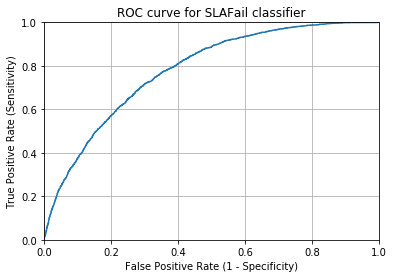

In [28]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SLAFail classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Capture resulting AUC

In [29]:
PipeLineMetadata['Metrics - AUC'] = metrics.roc_auc_score(y_test, y_pred_prob)
print("Metrics = AUC: %f " % PipeLineMetadata['Metrics - AUC']) 

Metrics = AUC: 0.780671 


## Save Details and Performance Measures for Comparison to other Models


In [30]:
PipeLineMetadata

{'Name': 'Bare Bones with WOE Encoder',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Classifier - Intercept': -0.9295458299205809,
 'Classifier - Coefficients':                                    0
 CI_Name_aff                 0.149429
 Service_Component_WBS_aff   0.020647
 Impact                      0.171251
 Urgency                     0.037602
 KM_number                   1.068385
 Count_Related_Interactions  1.175950
 Count_Related_Incidents     1.246824
 Count_Related_Changes       0.028382
 Open_Time_HourOfDay         0.183388
 Open_Time_DayOfWeek        -0.037186
 CI_TypeSubType_aff          0.003254,
 'Metrics - Cross Valida

In [31]:
with open("data/05.01.c BareBones WOE.pkl",'wb') as fo:
    pickle.dump(PipeLineMetadata, fo)

In [32]:
# with open("data/05.01.BareBones.pkl", 'rb') as fi:
#    BareBonesMetadata = pickle.load(fi)